In [1]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from scipy import signal
from scipy import linalg as la
from scipy import special as ss
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

参考サイト
https://dosuex.com/entry/2022/09/21/230624

# テスト用データ作成

In [2]:
def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq} >= 1. / {period}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal

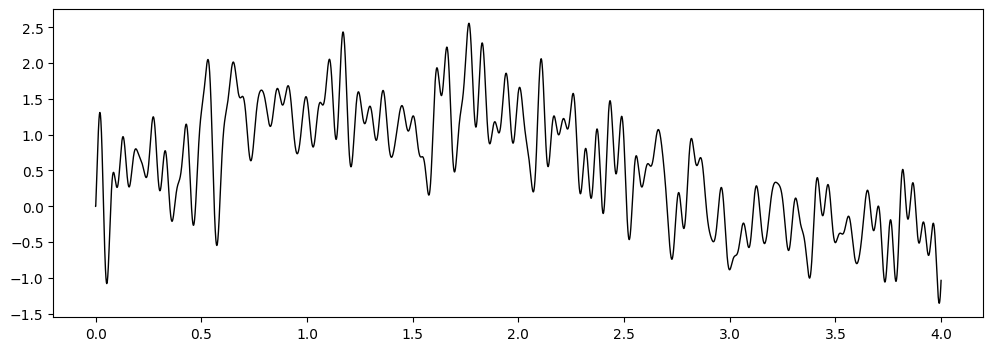

In [3]:
np.random.seed(0)

T=4
dt=5e-4
N=64
freq=20.0

vals = np.arange(0.0, T+dt, dt)
L = int(T / dt) + 1

u = torch.FloatTensor(whitesignal(T, dt, freq=freq))
u = F.pad(u, (1, 0))
u = u + torch.FloatTensor(
    np.sin(1.5 * np.pi / T * np.arange(0, T + dt, dt))
)  # add 3/4 of a sin cycle
u = u.to(device)

plt.figure(figsize=(12, 4))
offset = 0.0
plt.plot(vals, u.cpu() + offset, "k", linewidth=1.0)

In [4]:
def transition(N):
    # Legendre (scaled)
    # q = np.arange(N, dtype=np.float64)
    q = np.arange(N, dtype=np.float32)
    col, row = np.meshgrid(q, q)
    r = 2 * q + 1
    M = -(np.where(row >= col, r, 0) - np.diag(q))
    T = np.sqrt(np.diag(2 * q + 1))
    A = T @ M @ np.linalg.inv(T)
    B = np.diag(T)[:, None]
    B = (
        B.copy()
    )  # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    return A, B

# HiPPO行列の計算

In [5]:
A, B = transition(3)
B = B.squeeze(-1)

print(A)
print(B)

[[-1.         0.         0.       ]
 [-1.7320508 -1.9999999  0.       ]
 [-2.236068  -3.8729835 -3.       ]]
[1.        1.7320508 2.236068 ]


# 離散化した常微分方程式による時間発展

In [6]:
max_length = L
A, B = transition(N)
B = B.squeeze(-1)

A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
B_stacked = np.empty((max_length, N), dtype=B.dtype)

In [8]:
class HiPPOScale(nn.Module):
    """Vanilla HiPPO-LegS model (scale invariant instead of time invariant)"""
    
    def __init__(self, N, max_length=1024):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            # bilinear
            A_stacked[t - 1] = la.solve_triangular(
                np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True
            )
            B_stacked[t - 1] = la.solve_triangular(
                np.eye(N) - At / 2, Bt, lower=True
            )
        self.register_buffer("A_stacked", torch.Tensor(A_stacked))  # (max_length, N, N)
        self.register_buffer("B_stacked", torch.Tensor(B_stacked))  # (max_length, N)
    
    def forward(self, inputs):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        # 時系列信号を入力としてLTI方程式を解き、係数ベクトル c の時間発展を計算する
        L = inputs.shape[0]

        inputs = inputs.unsqueeze(-1)
        x = torch.transpose(inputs, 0, -2)
        x = x * self.B_stacked[:L]
        x = torch.transpose(x, 0, -2)  # (length, ..., N)

        c = torch.zeros(x.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):
            c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            cs.append(c)
        return torch.stack(cs, dim=0)
        
    def reconstruct(self, c):
        # 係数ベクトル c から、現在までの時系列信号を再構成する
        raise NotImplementedError

In [9]:
hippo = HiPPOScale(N=N, max_length=int(T / dt)+1).to(device)
cs = hippo(u)

In [10]:
print(cs.shape)
print(cs)

torch.Size([8001, 64])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.3562e-04,  2.7207e-04,  1.5053e-04,  ...,  1.9469e-11,
         -2.3281e-11,  1.7233e-11],
        [ 1.1005e-02,  1.4125e-02,  9.9080e-03,  ...,  6.9807e-10,
         -2.7768e-10, -5.0084e-10],
        ...,
        [ 6.1107e-01, -4.5706e-01, -3.7144e-01,  ...,  4.1828e-03,
         -2.0363e-02, -1.4803e-02],
        [ 6.1086e-01, -4.5731e-01, -3.7155e-01,  ...,  4.1581e-03,
         -2.0260e-02, -1.4424e-02],
        [ 6.1066e-01, -4.5755e-01, -3.7165e-01,  ...,  4.1496e-03,
         -2.0141e-02, -1.4033e-02]])


# 信号の再構成

In [11]:
vals = np.linspace(0.0, 1.0, max_length)

In [12]:
#測度関数

def measure_fn(c=0.0):
    # legs
    fn = lambda x: np.heaviside(x, 1.0) * np.exp(-x)
    
    fn_tilted = lambda x: np.exp(c * x) * fn(x)
    return fn_tilted

measure = measure_fn()(vals)

In [13]:
#基底関数
def basis(N, vals, c=0.0, truncate_measure=True):
    """
    vals: list of times (forward in time)
    returns: shape (T, N) where T is length of vals
    """
    # legs
    _vals = np.exp(-vals)
    eval_matrix = ss.eval_legendre(np.arange(N)[:, None], 1 - 2 * _vals).T  # (L, N)
    eval_matrix *= (2 * np.arange(N) + 1) ** 0.5 * (-1) ** np.arange(N)
    
    if truncate_measure:
        eval_matrix[measure_fn()(vals) == 0.0] = 0.0
    
    p = torch.tensor(eval_matrix)
    p *= np.exp(-c * vals)[:, None]  # [::-1, None]
    return p

eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T)

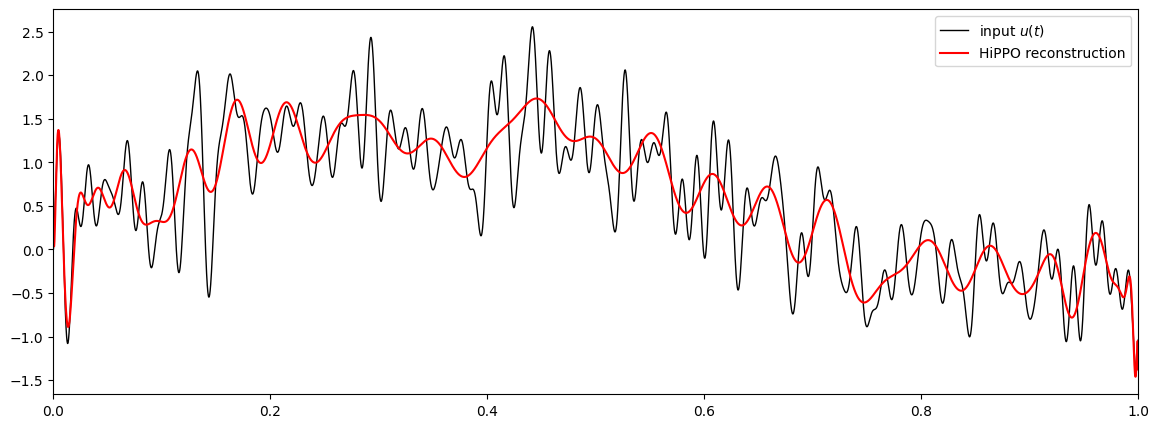

In [14]:
#再構成
rec = eval_matrix.to(cs) @ cs.unsqueeze(-1)

plt.figure(figsize=(14, 5))
offset = 0.0
plt.plot(vals, u.cpu() + offset, "k", linewidth=1.0, label="input $u(t)$")
plt.plot(vals, rec[-1], label="HiPPO reconstruction", color="red")
plt.xlim(0,1)
plt.legend()